<a href="https://colab.research.google.com/github/NganTran-0017/HIDS/blob/main/ML_HIDS_ADFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Processing data**

In [1]:
#@title Specify parameters before running
# Indicate to clean data or not. Used in Data Cleaning section

CLEAN = True #@param {type:"boolean"} 
SZ =  1#@param {type:"number"}         # Indicate a fraction number to sample train set when it's too big. Located in Data Partition

SEQ_WINDOW =  25#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix

from sklearn.model_selection import train_test_split
%matplotlib inline

DATA = 'ADFA-LD'

import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [3]:
# Load data and unzip them
! wget 'https://github.com/NganTran-0017/HIDS/blob/main/Datasets/ADFA-LD/Training_Data_Master.zip?raw=true'
! wget 'https://github.com/NganTran-0017/HIDS/blob/main/Datasets/ADFA-LD/Attack_Data_Master.zip?raw=true'


--2022-01-29 23:08:09--  https://github.com/NganTran-0017/HIDS/blob/main/Datasets/ADFA-LD/Training_Data_Master.zip?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/NganTran-0017/HIDS/raw/main/Datasets/ADFA-LD/Training_Data_Master.zip [following]
--2022-01-29 23:08:09--  https://github.com/NganTran-0017/HIDS/raw/main/Datasets/ADFA-LD/Training_Data_Master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/ADFA-LD/Training_Data_Master.zip [following]
--2022-01-29 23:08:09--  https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/ADFA-LD/Training_Data_Master.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to r

In [4]:
# Rename files
! mv Attack_Data_Master.zip?raw=true   Attack_Data_Master.zip
! mv Training_Data_Master.zip?raw=true Training_Data_Master.zip

# Unzip files
! unzip Training_Data_Master.zip
! unzip Attack_Data_Master.zip

Archive:  Training_Data_Master.zip
  inflating: Training_Data_Master/UTD-0001.txt  
  inflating: Training_Data_Master/UTD-0002.txt  
  inflating: Training_Data_Master/UTD-0003.txt  
  inflating: Training_Data_Master/UTD-0004.txt  
  inflating: Training_Data_Master/UTD-0005.txt  
  inflating: Training_Data_Master/UTD-0006.txt  
  inflating: Training_Data_Master/UTD-0007.txt  
  inflating: Training_Data_Master/UTD-0008.txt  
  inflating: Training_Data_Master/UTD-0009.txt  
  inflating: Training_Data_Master/UTD-0010.txt  
  inflating: Training_Data_Master/UTD-0011.txt  
  inflating: Training_Data_Master/UTD-0012.txt  
  inflating: Training_Data_Master/UTD-0013.txt  
  inflating: Training_Data_Master/UTD-0014.txt  
  inflating: Training_Data_Master/UTD-0015.txt  
  inflating: Training_Data_Master/UTD-0016.txt  
  inflating: Training_Data_Master/UTD-0017.txt  
  inflating: Training_Data_Master/UTD-0018.txt  
  inflating: Training_Data_Master/UTD-0019.txt  
  inflating: Training_Data_Master/

**Syscall sequences in ADFA-LD are organized by folder, so we assume that they are already grouped by PID**

In [5]:
from glob import glob
import os
train_dir = 'Training_Data_Master/'
test_dir  = 'Attack_Data_Master/'

# Read data in a dataframe
def read_in_data(path, is_normal = 1): 
  lines = []
  if is_normal == 1:
    for filename in os.listdir(path): # iterate through all label folders in a directory 
      with open(path+filename) as f:
        lines.append(f.read())
       # data = pd.read_csv(path+filename, sep=' ', header=None)
       # list_of_dataframes.append(data.stack())
    
  else:
    for folder in os.listdir(path): # iterate through different attack folders in a directory
      files = glob(str(path + folder +"/*.txt"), recursive=False) # get a list of files from each label folder 
      for filename in files: 
        with open(filename) as f:
          lines.append(f.read())
        #data = pd.read_csv(filename, sep=' ', header=None)
        #lines.append(data.stack())

  df = pd.DataFrame(lines)
  #df = df.astype('int32')
  #df = pd.DataFrame(df)
  return df   

In [6]:
# Trainning set
train = read_in_data(train_dir)
train.rename(columns={0:'Syscall Sequence'}, inplace=True)

print('Normal training data size:', train.shape)
train.head(5)

Normal training data size: (833, 1)


,Syscall Sequence
0,311 78 265 240 240 240 196 240 78 265 240 240 ...
1,174 6 5 221 220 221 221 221 221 221 221 221 22...
2,195 220 195 195 195 195 195 195 195 195 220 6 ...
3,6 63 6 11 5 192 6 192 192 125 125 125 125 54 4...
4,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...


In [7]:
# Testing set
test = read_in_data(test_dir, is_normal = 0)
test.rename(columns={0:'Syscall Sequence'}, inplace=True)

print('Intrusion Testing data size:', test.shape)
test.head(5)

Intrusion Testing data size: (746, 1)


,Syscall Sequence
0,3 3 3 3 142 3 142 3 142 3 142 175 104 175 142 ...
1,168 168 3 168 43 168 43 168 168 3 168 265 43 1...
2,201 192 192 192 78 240 45 78 78 3 78 78 78 78 ...
3,5 91 5 5 125 5 3 192 78 125 192 78 78 192 240 ...
4,3 168 168 3 265 168 265 168 146 168 3 265 168 ...


## **EDA - Histogram of original data**



plt.figure(figsize=(20,6))
plt.hist(train['Syscall Sequence'], label='Normal', alpha=0.6, density=True)
plt.hist(test['Syscall Sequence'], label='Intrusion', color='tomato', alpha=0.6, density=True)
plt.legend()
plt.ylabel('Proportions')
plt.xlabel('Syscall num')
plt.grid(axis='y', alpha=0.75)
plt.title('An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ' + DATA,y=1.02, fontsize=15)

## **Data Parsing**

In [8]:
from nltk.tokenize import word_tokenize
from nltk import ngrams


## Parse an entire Syscall seq per PID into smaller sequences of size 15
def parse_seq(seq_per_pid):
  sequences = pd.DataFrame()
  for p in seq_per_pid.index:
    token = word_tokenize(seq_per_pid.iloc[p]['Syscall Sequence'])  # Tokenize the string of sequence

    # Parse the sequence into length of SEQ_WINDOW
    sequences=sequences.append(list(nltk.ngrams(token, SEQ_WINDOW, pad_right=True, right_pad_symbol=-1)))
    #print('PID %d - seq len: %d'% (p, len(sequences)))
  return sequences

normal = parse_seq(train)
normal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,311,78,265,240,240,240,196,240,78,265,240,240,265,240,240,240,196,240,240,78,265,240,240,196,78
1,78,265,240,240,240,196,240,78,265,240,240,265,240,240,240,196,240,240,78,265,240,240,196,78,265
2,265,240,240,240,196,240,78,265,240,240,265,240,240,240,196,240,240,78,265,240,240,196,78,265,240
3,240,240,240,196,240,78,265,240,240,265,240,240,240,196,240,240,78,265,240,240,196,78,265,240,240
4,240,240,196,240,78,265,240,240,265,240,240,240,196,240,240,78,265,240,240,196,78,265,240,240,240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,118,195,38,38,6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
817,195,38,38,6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
818,38,38,6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
819,38,6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [9]:
print('Parsing Intrusion')
intrusion = parse_seq(test)
intrusion

Parsing Intrusion


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,3,3,3,3,142,3,142,3,142,3,142,175,104,175,142,265,3,104,175,175,3,142,142,104,146
1,3,3,3,142,3,142,3,142,3,142,175,104,175,142,265,3,104,175,175,3,142,142,104,146,3
2,3,3,142,3,142,3,142,3,142,175,104,175,142,265,3,104,175,175,3,142,142,104,146,3,142
3,3,142,3,142,3,142,3,142,175,104,175,142,265,3,104,175,175,3,142,142,104,146,3,142,3
4,142,3,142,3,142,3,142,175,104,175,142,265,3,104,175,175,3,142,142,104,146,3,142,3,146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,91,5,197,192,192,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
123,5,197,192,192,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
124,197,192,192,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
125,192,192,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


 ## **Data Cleaning**
 Remove rows that exist in both normal and intrusion df

In [10]:
## Get % of duplicates in both datasets

# Convert normal df to set, and intrusion df to set
def clean_data(normal, intrusion):
  normal_list = normal.values.tolist()
  intrusion_list = intrusion.values.tolist()
  normal_set = set(tuple(i) for i in normal_list)
  intrusion_set = set(tuple(i) for i in intrusion_list)
  print('List sz vs. Set sz of normal sequences: %d vs. %d'% (len(normal_list),len(normal_set)) )
  print('List sz vs. Set sz of intrusion sequences: %d vs. %d'% (len(intrusion_list),len(intrusion_set)) )
    
  normal_dupplication = (len(normal_list) - len(normal_set)) /len(normal_list)*100 
  intrusion_duplication = (len(intrusion_list)-len(intrusion_set))/len(intrusion_list) * 100
  print('Duplication Rate in Normal Class: %.2f%%'% normal_dupplication )
  print('Duplication Rate in Intrusion Class: %.2f%%'% intrusion_duplication) 

  c_intrusion = intrusion_set - normal_set
  #c_normal = normal_set - intrusion_set
  if len(c_intrusion) == 0 and len(c_normal) == 0:
    print(DATA+' No Duplication!')
  if len(c_intrusion) > 0:
    intrusion = pd.DataFrame(c_intrusion)
  else:
    intrusion = pd.DataFrame(intrusion_set)
  #if len(c_normal) > 0:
  #  normal = pd.DataFrame(c_normal)
  #else:
  normal = pd.DataFrame(normal_set)

  print('After cleaning: \nNormal sz:', len(normal), ' Intrusion sz:', len(c_intrusion) )
  return normal, intrusion

if CLEAN:  # Only clean data when the boolean CLEAN is on, at the beginning
  normal, intrusion = clean_data(normal, intrusion) # since train set contains only normal, it is passed in the func as normal. Similar to test

List sz vs. Set sz of normal sequences: 308077 vs. 174215
List sz vs. Set sz of intrusion sequences: 317388 vs. 299392
Duplication Rate in Normal Class: 43.45%
Duplication Rate in Intrusion Class: 5.67%
After cleaning: 
Normal sz: 174215  Intrusion sz: 298521


In [ ]:
len(normal), len(intrusion)

(102097, 173825)

## **Histogram of Processed Data**

Text(0.5, 1.02, 'An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ADFA-LD')

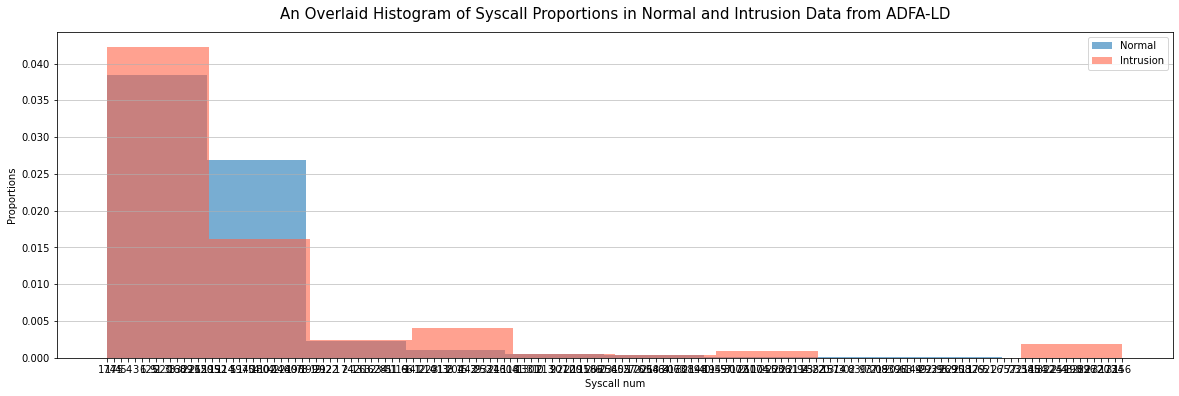

In [ ]:
# After Cleaning
plt.figure(figsize=(20,6))
plt.hist(normal[0], label='Normal', alpha=0.6, density=True)
plt.hist(intrusion[0], label='Intrusion', color='tomato', alpha=0.6, density=True)
plt.legend()
plt.ylabel('Proportions')
plt.xlabel('Syscall num')
plt.grid(axis='y', alpha=0.75)
plt.title('An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ' + DATA,y=1.02, fontsize=15)

In [ ]:
# Save cleaned train and test sets
normal.to_csv('normal.csv', index=False)
intrusion.to_csv('intrusion.csv', index=False)

**Labeling Sequences**

In [ ]:
# Intrusion sequences is labeled 1.
intrusion['Label'] = 1
intrusion.head(5)

,0,1,2,3,4,5,6,7,8,9,Label
0,265,168,168,265,168,265,168,168,265,168,1
1,7,142,142,142,142,7,142,142,7,142,1
2,265,265,265,265,3,3,168,265,168,168,1
3,142,3,265,3,265,3,3,91,175,175,1
4,265,3,265,43,265,3,265,43,168,265,1


In [ ]:
# Normal sequences is labeled 0.
print('Normal len:',len(normal),'\nIntrusion len:', len(intrusion))
normal['Label'] = 0
normal.head(5)

Normal len: 102097 
Intrusion len: 173825


,0,1,2,3,4,5,6,7,8,9,Label
0,174,45,3,3,195,195,195,195,195,195,0
1,175,5,175,175,120,175,175,175,120,175,0
2,45,45,45,91,6,197,192,3,3,6,0
3,4,4,7,308,7,4,308,3,162,7,0
4,3,4,3,4,33,5,5,5,5,141,0


## **Partition Training and Testing dataset 70/30**

We do not need to bootstrap since there are more than enough data from both classes.

In [ ]:
# combine normal(train) and intrusion(test) data and split them into training and testing sets
df = normal.append(intrusion, ignore_index=True).astype(int)
print('Df sz:', df.shape)

# Spliting into training and testing
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df['Label'], test_size = 0.30, shuffle=True)

# Reset index of training and testing sets
x_train.reset_index(drop=True, inplace=True); y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True);  y_test.reset_index(drop=True, inplace=True)

print('Train sz:',len(x_train), len(y_train))
intrusion_train = y_train.loc[y_train == 1]
normal_train = y_train.loc[y_train == 0]
print('Train set: Intrusion vs. Normal cases', len(y_train.iloc[intrusion_train] ), len(y_train.iloc[normal_train] ))

print('Test sz:', len(x_test), len(y_test))
intrusion_test = y_test.loc[y_test == 1]
normal_test = y_test.loc[y_test == 0]
print('Test set: Intrusion vs. Normal cases', len(y_test.iloc[intrusion_test] ), len(y_test.iloc[normal_test] ))

Df sz: (275922, 11)
Train sz: 193145 193145
Train set: Intrusion vs. Normal cases 121773 71372
Test sz: 82777 82777
Test set: Intrusion vs. Normal cases 52052 30725


In [ ]:
# SZ proportion is used when duplicated training data is not removed and the training sz is too big
#SZ = 1

x_train['Label'] = y_train

#x_train = x_train.append(x_train.sample(frac=1), ignore_index=True) # Bootstrap training data in case there is not enough data
x_train = x_train.sample(frac= SZ) # Shuffle data with a SZ proportion
x_train.reset_index(drop=True, inplace=True)
y_train = x_train['Label']
x_train.drop(columns='Label', inplace=True)
x_train

,0,1,2,3,4,5,6,7,8,9
0,3,146,142,142,142,265,142,265,175,175
1,6,195,195,195,195,195,3,6,3,6
2,146,168,3,168,13,146,168,3,265,3
3,265,168,265,265,168,3,265,3,265,3
4,220,192,196,192,3,3,4,78,122,192
...,...,...,...,...,...,...,...,...,...,...
193140,174,174,174,174,174,174,174,174,272,197
193141,3,13,199,5,140,197,33,102,91,142
193142,142,7,142,7,7,7,142,7,142,142
193143,146,142,3,265,3,3,265,142,3,3


In [ ]:
x_train

,0,1,2,3,4,5,6,7,8,9
0,3,146,142,142,142,265,142,265,175,175
1,6,195,195,195,195,195,3,6,3,6
2,146,168,3,168,13,146,168,3,265,3
3,265,168,265,265,168,3,265,3,265,3
4,220,192,196,192,3,3,4,78,122,192
...,...,...,...,...,...,...,...,...,...,...
193140,174,174,174,174,174,174,174,174,272,197
193141,3,13,199,5,140,197,33,102,91,142
193142,142,7,142,7,7,7,142,7,142,142
193143,146,142,3,265,3,3,265,142,3,3


In [ ]:
y_train

0         1
1         0
2         1
3         1
4         1
         ..
193140    0
193141    1
193142    1
193143    1
193144    0
Name: Label, Length: 193145, dtype: int64

In [ ]:
x_test

,0,1,2,3,4,5,6,7,8,9
0,265,168,3,3,168,3,265,168,3,43
1,168,3,168,265,168,168,168,168,3,168
2,240,240,240,4,78,4,4,4,240,240
3,85,27,27,102,309,309,102,27,309,10
4,45,3,3,3,3,45,45,3,3,6
...,...,...,...,...,...,...,...,...,...,...
82772,174,174,45,5,197,91,5,3,3,201
82773,265,3,265,265,168,265,265,265,168,265
82774,5,155,157,78,5,5,3,220,195,240
82775,102,27,5,102,102,102,309,195,195,265



# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale
4.   Graphing overlaid ROC curves, where each one represents a model AUC score





In [ ]:
# This function calculate False Positive Rate given a confusion matrix
def calc_false_positive (cmatrix):
  specificity = cmatrix[0,0]/(cmatrix[0,0] + cmatrix[0,1])
  return 1-specificity

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance( model_name, true_labels, pred_labels):
  # rows are actual, columns are predicted
  cmatrix = confusion_matrix(true_labels, pred_labels)
  fpr = calc_false_positive(cmatrix)

  print('Confusion Matrix: \n',cmatrix)
  print('\nTesting Accuracy: %.2f'% metrics.accuracy_score(true_labels, pred_labels))
  print('Precision:%.2f'%  metrics.precision_score(true_labels, pred_labels))
  print('Recall: %.2f'% metrics.recall_score(true_labels, pred_labels))
  print('False Positive Rate: %.2f'% fpr)
  print('\nClassification report:', classification_report(true_labels, pred_labels), sep='\n')
  print('AUC: %.2f'% roc_auc_score(true_labels, pred_labels))

  false_positive_rate, recall, thresholds = roc_curve(true_labels, pred_labels)
  roc_auc = auc(false_positive_rate, recall)
  plt.figure()
  if CLEAN: clean_status='Clean '
  else: clean_status ='Overlapped and Duplicated '
  plt.title( model_name+' ROC Curve on '+ clean_status + DATA + ' with Seq Len of '+ str(SEQ_WINDOW))
  plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.2f' %roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1], [0,1], 'r--')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.1])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  #plt.savefig(model_name+'-ROC.jpg')
  plt.show()

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix( model_name, model, x_test, y_test, y_predicted):
  class_names = ['Normal', 'Intrusion']

  fig, ax = plt.subplots(figsize=(6, 6))
  plot_confusion_matrix(model, x_test, y_test, display_labels=class_names, 
                        values_format='d', ax = ax, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of ' + str(model_name))
  #plt.savefig(model_name+'-CM.jpg')
  plt.show()

  cmatrix = confusion_matrix(y_test, y_predicted)
  print(cmatrix)


# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC ():
  # Set color for each model
  colors = {'KM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'NN': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'KM':'1--','LR': 'v--', 'SVM': '^--', 'NN': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))

  plt.plot(KM_test.get('fpr'), KM_test.get('tpr'), markers.get('KM'), color=colors.get('KM'),  label="KM - AUC=" + str(KM_test.get('auc').round(3)))
  plt.plot(LR_test.get('fpr'), LR_test.get('tpr'), markers.get('LR'), color=colors.get('LR'),  label="LR - AUC=" + str(LR_test.get('auc').round(3)))
  plt.plot(SVM_test.get('fpr'),SVM_test.get('tpr'),markers.get('SVM'),color=colors.get('SVM'), label="SVM - AUC="+ str(SVM_test.get('auc').round(3)))
  plt.plot(NN_test.get('fpr'), NN_test.get('tpr'), markers.get('NN'), color=colors.get('NN'),  label="NN - AUC=" + str(NN_test.get('auc').round(3)))
  plt.plot(DT_test.get('fpr'), DT_test.get('tpr'), markers.get('DT'), color=colors.get('DT'),  label="DT - AUC=" + str(DT_test.get('auc').round(3)))
  plt.plot(RF_test.get('fpr'), RF_test.get('tpr'), markers.get('RF'), color=colors.get('RF'),  label="RF - AUC=" + str(RF_test.get('auc').round(3)))
  plt.plot(KNN_test.get('fpr'),KNN_test.get('tpr'),markers.get('KNN'),color=colors.get('KNN'), label="KNN - AUC="+ str(KNN_test.get('auc').round(3)))
  plt.plot(NB_test.get('fpr'), NB_test.get('tpr'), markers.get('NB'), color=colors.get('NB'),  label="NB - AUC=" + str(NB_test.get('auc').round(3)))
  plt.plot(BERT_test.get('fpr'),BERT_test.get('tpr'), markers.get('BERT'), color=colors.get('BERT'),  label="BERT - AUC="+ str(BERT_test.get('auc').round(3)))
  plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'Testing ROCs on ' + DATA)
  #plt.savefig(DATA_I+'-'+train_or_test+'.jpg', dpi = 80)
  plt.show()

# **K-means**

Confusion Matrix: 
 [[19967 10758]
 [19474 32578]]

Testing Accuracy: 0.63
Precision:0.75
Recall: 0.63
False Positive Rate: 0.35

Classification report:
              precision    recall  f1-score   support

           0       0.51      0.65      0.57     30725
           1       0.75      0.63      0.68     52052

    accuracy                           0.63     82777
   macro avg       0.63      0.64      0.63     82777
weighted avg       0.66      0.63      0.64     82777

AUC: 0.64


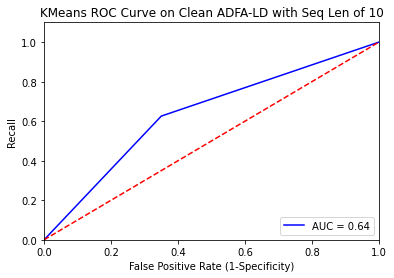

Number of iterations before converging: 8
Train AUC: 0.640 vs Test AUC: 0.638


In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score

# Choose K cluster = 2
kmeans = KMeans(n_clusters=2)
# Fit Kmeans to the training set
kmeans.fit(x_train)


# Recording TPR and FPR for the TRAINING ROC curves
y_pred = kmeans.predict(x_train)
KM_train = {}
KM_train['fpr'], KM_train['tpr'], thresh = roc_curve(y_train, y_pred)
KM_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING K-MEANS
y_predicted = kmeans.predict(x_test)

print_performance('KMeans',y_test, y_predicted)

# Number of iterations before converging
print('Number of iterations before converging:', kmeans.n_iter_)


# Recording TPR and FPR for the TESTING ROC curves
KM_test = {}
KM_test['fpr'], KM_test['tpr'], thresh = roc_curve(y_test, y_predicted)
KM_test['auc'] = roc_auc_score(y_test, y_predicted)


print('Train AUC: %.3f vs Test AUC: %.3f' %(KM_train['auc'], KM_test['auc']))

# **Logistic Regression**

Confusion Matrix: 
 [[10558 20167]
 [ 5986 46066]]

Testing Accuracy: 0.68
Precision:0.70
Recall: 0.88
False Positive Rate: 0.66

Classification report:
              precision    recall  f1-score   support

           0       0.64      0.34      0.45     30725
           1       0.70      0.88      0.78     52052

    accuracy                           0.68     82777
   macro avg       0.67      0.61      0.61     82777
weighted avg       0.67      0.68      0.66     82777

AUC: 0.61


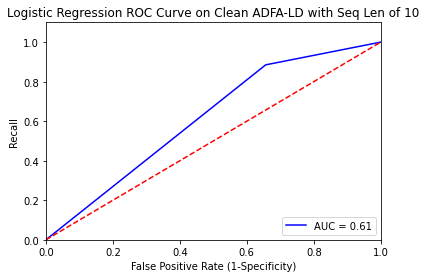

Train AUC: 0.619 vs Test AUC: 0.614


In [ ]:
from sklearn.linear_model import LogisticRegression

# Fit the model on the training set and predict the testing set
lgModel = LogisticRegression().fit(x_train, y_train)
y_pred = lgModel.predict(x_train)

# Recording TPR and FPR for the TESTING ROC curves
LR_train = {}
LR_train['fpr'], LR_train['tpr'], thresh = roc_curve(y_train, y_pred)
LR_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING Logistic Regression
y_predicted = lgModel.predict(x_test)

# Evaluating Performance on Testing data
print_performance('Logistic Regression',y_test, y_predicted)

# Recording TPR and FPR for the multi-ROC curves
LR_test = {}
LR_test['fpr'], LR_test['tpr'], thresh = roc_curve(y_test, y_predicted)
LR_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(LR_train['auc'], LR_test['auc']))

# **SVM**

This model uses a Polynomial kernel, and the rest of the parameters are as default






In [ ]:
if len(x_train) > 500000: 
  svm_sz = 0.1  
elif len(x_train) > 100000:
  svm_sz = 0.2
else:
  svm_sz = 1

svm_sz

0.2

In [ ]:
train_data = x_train.copy(deep=True) # create a deep copy of x_train, so any modification to train_data won't affect x_train
train_data['Label'] = y_train
train_data = train_data.groupby('Label').sample(frac = svm_sz)
train_data.reset_index(drop=True, inplace= True)
#train_data
svm_x_train = train_data.drop(columns='Label')
svm_y_train = train_data['Label']
svm_x_train

,0,1,2,3,4,5,6,7,8,9
0,265,19,3,240,78,78,265,240,240,265
1,3,140,140,6,3,3,3,6,3,3
2,3,3,19,3,19,3,3,3,3,19
3,195,6,6,5,6,195,5,197,192,6
4,5,6,6,6,195,5,5,5,6,5
...,...,...,...,...,...,...,...,...,...,...
38624,4,4,175,175,175,175,5,4,307,5
38625,168,168,43,3,43,168,195,340,3,168
38626,146,265,146,142,3,104,142,104,175,146
38627,168,265,265,168,43,265,3,168,265,43



****Polynomial kernel model: 
[LibSVM]Confusion Matrix: 
 [[16142 14583]
 [13387 38665]]

Testing Accuracy: 0.66
Precision:0.73
Recall: 0.74
False Positive Rate: 0.47

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.53      0.54     30725
           1       0.73      0.74      0.73     52052

    accuracy                           0.66     82777
   macro avg       0.64      0.63      0.64     82777
weighted avg       0.66      0.66      0.66     82777

AUC: 0.63


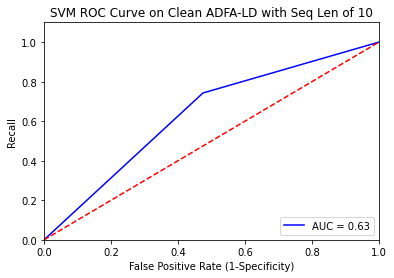

Train AUC: 0.644 vs Test AUC: 0.634


In [ ]:
from sklearn import svm

#### Create a SVM classifier using polynomial Kernel
print('\n****Polynomial kernel model: ')
svm_model = svm.SVC(kernel = 'poly', verbose = True)

#Train the  & Get accuracy from training
svm_model.fit(svm_x_train, svm_y_train)
y_pred = svm_model.predict(svm_x_train)

# Recording TPR and FPR for plotting TRAINING ROC curves
SVM_train = {}
SVM_train['fpr'], SVM_train['tpr'], thresh = roc_curve(svm_y_train, y_pred)
SVM_train['auc'] = roc_auc_score(svm_y_train, y_pred)


# Test the model w testing data
y_predicted = svm_model.predict(x_test)

# Evaluate the model 
print_performance('SVM', y_test, y_predicted)

# Recording TPR and FPR for TESTING-ROC curves
SVM_test = {}
SVM_test['fpr'], SVM_test['tpr'], thresh = roc_curve(y_test, y_predicted)
SVM_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(SVM_train['auc'], SVM_test['auc']))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


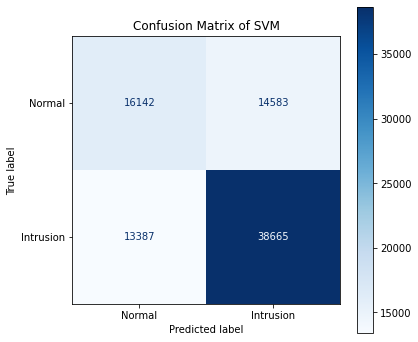

[[16142 14583]
 [13387 38665]]


In [ ]:
# Plot a heatmap confusion matrix
color_confusion_matrix('SVM', svm_model, x_test, y_test, y_predicted)

# **Neural Net**

This model contains 3 layers: input layer of 6 nodes, a fully connected layer of 6 nodes and an output layer of 2 nodes

In [ ]:
# Scale syscall number to between 0 and 1
# The maximum syscall number in ADFA-LD data is 325
max_syscall = 325
x_train_nn = x_train/max_syscall
x_test_nn = x_test/max_syscall

In [ ]:
import tensorflow as tf
from tensorflow import keras
INPUT_SZ = len(x_train.columns)
nn_model = keras.Sequential([
    keras.layers.Input(shape = (INPUT_SZ,)),  # model expect input to be a vector of 6 numbers
    keras.layers.Dense(INPUT_SZ, activation = 'relu'),
    keras.layers.Dense(2, activation = 'sigmoid')
])

nn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model to training set
history = nn_model.fit(x_train_nn, y_train, epochs=10, batch_size=128, verbose=1)  # we pass the data, labels and epochs and watch the magic!

Epoch 1/10
1509/1509 [==============================] - 3s 2ms/step - loss: 0.6130 - accuracy: 0.6781
Epoch 2/10
1509/1509 [==============================] - 3s 2ms/step - loss: 0.6043 - accuracy: 0.6883
Epoch 3/10
1509/1509 [==============================] - 3s 2ms/step - loss: 0.6019 - accuracy: 0.6878
Epoch 4/10
1509/1509 [==============================] - 3s 2ms/step - loss: 0.5998 - accuracy: 0.6883
Epoch 5/10
1509/1509 [==============================] - 3s 2ms/step - loss: 0.5979 - accuracy: 0.6885
Epoch 6/10
1509/1509 [==============================] - 3s 2ms/step - loss: 0.5932 - accuracy: 0.6902
Epoch 7/10
1509/1509 [==============================] - 2s 2ms/step - loss: 0.5877 - accuracy: 0.6928
Epoch 8/10
1509/1509 [==============================] - 3s 2ms/step - loss: 0.5833 - accuracy: 0.6955
Epoch 9/10
1509/1509 [==============================] - 3s 2ms/step - loss: 0.5796 - accuracy: 0.6987
Epoch 10/10
1509/1509 [==============================] - 3s 2ms/step - loss: 0.576

In [ ]:
# Get predict Training classes
y_pred = np.argmax(nn_model.predict(x_train_nn), axis=-1)

# Recording TPR and FPR for the TRAINING ROC curves
NN_train = {}
NN_train['fpr'], NN_train['tpr'], thresh = roc_curve(y_train, y_pred)
NN_train['auc'] = roc_auc_score(y_train, y_pred)

2587/2587 [==============================] - 4s 1ms/step - loss: 0.5791 - accuracy: 0.6961
Test accuracy: 0.6960870623588562  Test loss: 0.5790693759918213
Confusion Matrix: 
 [[11169 19556]
 [ 5601 46451]]

Testing Accuracy: 0.70
Precision:0.70
Recall: 0.89
False Positive Rate: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.36      0.47     30725
           1       0.70      0.89      0.79     52052

    accuracy                           0.70     82777
   macro avg       0.68      0.63      0.63     82777
weighted avg       0.69      0.70      0.67     82777

AUC: 0.63


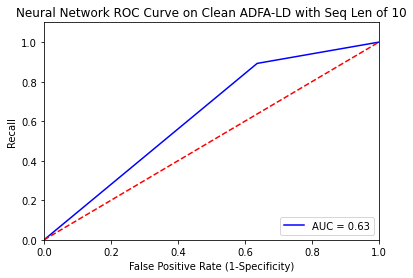

Train AUC: 0.632 vs Test AUC: 0.628


In [ ]:
# Get the loss and accuracy on testing set
test_loss, test_acc = nn_model.evaluate(x_test_nn,  y_test, verbose=1) 
y_predicted = np.argmax(nn_model.predict(x_test_nn), axis=-1)


print('Test accuracy:', test_acc,' Test loss:', test_loss)
print_performance('Neural Network',y_test, y_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
NN_test = {}
NN_test['fpr'], NN_test['tpr'], thresh = roc_curve(y_test, y_predicted)
NN_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(NN_train['auc'], NN_test['auc']))

In [ ]:
nn_model.summary()

#history.history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 132
Trainable params: 132
Non-trainable params: 0
_________________________________________________________________


# **Decision Tree**

This model uses GINI criterion to split the data and requires at least 10 observations to split and 5 observations in the leaf.

Confusion Matrix: 
 [[24820  5905]
 [ 6279 45773]]

Testing Accuracy: 0.85
Precision:0.89
Recall: 0.88
False Positive Rate: 0.19

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80     30725
           1       0.89      0.88      0.88     52052

    accuracy                           0.85     82777
   macro avg       0.84      0.84      0.84     82777
weighted avg       0.85      0.85      0.85     82777

AUC: 0.84


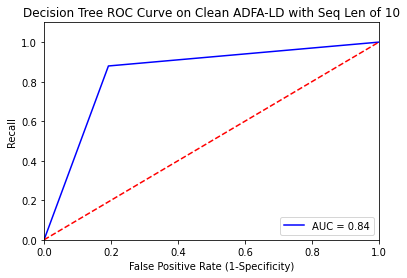

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


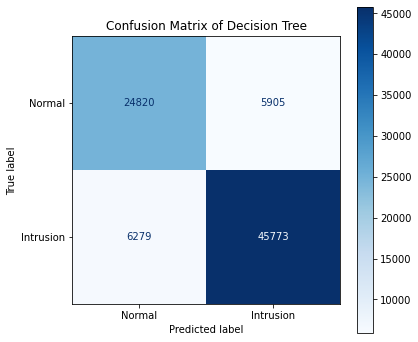

[[24820  5905]
 [ 6279 45773]]
Train AUC: 0.909 vs Test AUC: 0.844


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create and Train DecTree model
decTree = DecisionTreeClassifier(criterion='gini', min_samples_split=10,min_samples_leaf=5,max_features='auto')
decTree = decTree.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = decTree.predict(x_train)
DT_train = {}
DT_train['fpr'], DT_train['tpr'], thresh = roc_curve(y_train, y_pred)
DT_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict testing data
y_predicted = decTree.predict(x_test)

# Print performance measures
print_performance('Decision Tree',y_test, y_predicted)

# Color Confusion Matrix
color_confusion_matrix('Decision Tree', decTree, x_test, y_test, y_predicted)

# Recording TPR and FPR for TESTING-ROC curves
DT_test = {}
DT_test['fpr'], DT_test['tpr'], thresh = roc_curve(y_test, y_predicted)
DT_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(DT_train['auc'], DT_test['auc']))

# **Random Forest**

This model has no max depth and allows bootstrapping observations during training. It uses GINI criterion to split and requires a minimum of 10 observations to split and the leaf node must have above 5 observations.




Confusion Matrix: 
 [[26971  3754]
 [ 4070 47982]]

Testing Accuracy: 0.91
Precision:0.93
Recall: 0.92
False Positive Rate: 0.12

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     30725
           1       0.93      0.92      0.92     52052

    accuracy                           0.91     82777
   macro avg       0.90      0.90      0.90     82777
weighted avg       0.91      0.91      0.91     82777

AUC: 0.90


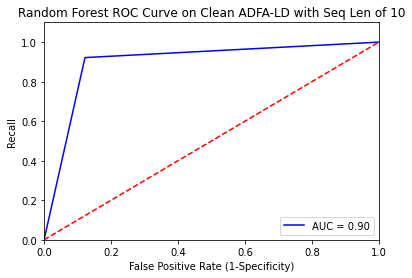

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


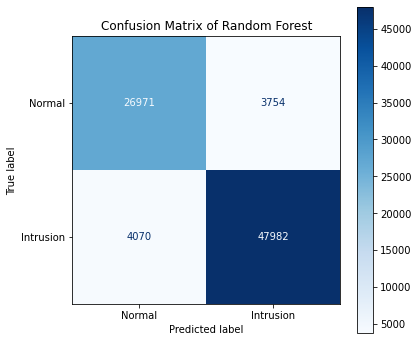

[[26971  3754]
 [ 4070 47982]]
Train AUC: 0.949 vs Test AUC: 0.900


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Build model
randomForest = RandomForestClassifier(max_depth=None, min_samples_split=10, min_samples_leaf=5, 
                                      max_features='auto', bootstrap=True,verbose=0, criterion='gini')
# Train the model with training set
randomForest.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = randomForest.predict(x_train)
RF_train = {}
RF_train['fpr'], RF_train['tpr'], thresh = roc_curve(y_train, y_pred)
RF_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict the labels for testing set
y_predicted = randomForest.predict(x_test)

# Print performance measures
print_performance('Random Forest',y_test, y_predicted)

# Color Confusion Matrix
color_confusion_matrix('Random Forest', randomForest, x_test, y_test, y_predicted)

# Recording TPR and FPR for the multi-ROC curves
RF_test = {}
RF_test['fpr'], RF_test['tpr'], thresh = roc_curve(y_test, y_predicted)
RF_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(RF_train['auc'], RF_test['auc']))

# **KNN**

This model classifies each observation based on 3 nearest neighbors with uniform weight.

Confusion Matrix: 
 [[22639  8086]
 [10288 41764]]

Testing Accuracy: 0.78
Precision:0.84
Recall: 0.80
False Positive Rate: 0.26

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.74      0.71     30725
           1       0.84      0.80      0.82     52052

    accuracy                           0.78     82777
   macro avg       0.76      0.77      0.77     82777
weighted avg       0.78      0.78      0.78     82777

AUC: 0.77


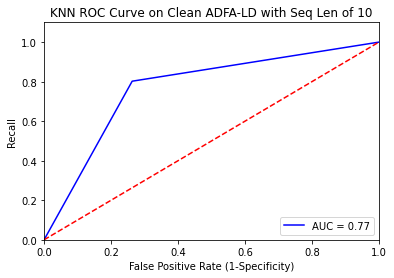

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


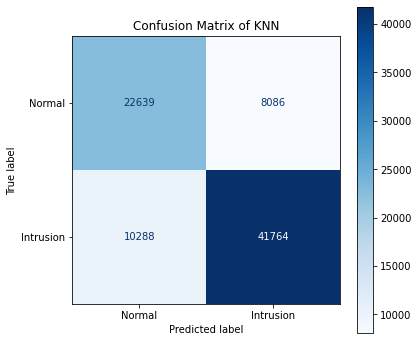

[[22639  8086]
 [10288 41764]]
Train AUC: 0.817 vs Test AUC: 0.770


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Creat and Train KNN model
KNN = KNeighborsClassifier(n_neighbors=9, weights='uniform')
KNN.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = KNN.predict(x_train)
KNN_train = {}
KNN_train['fpr'], KNN_train['tpr'], thresh = roc_curve(y_train, y_pred)
KNN_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict testing data
y_predicted = KNN.predict(x_test)

# Print performance measures
print_performance('KNN',y_test, y_predicted)

# Color Confusion Matrix
color_confusion_matrix('KNN', KNN, x_test, y_test, y_predicted)

# Recording TPR and FPR for TESTING-ROC curves
KNN_test = {}
KNN_test['fpr'], KNN_test['tpr'], thresh = roc_curve(y_test, y_predicted)
KNN_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(KNN_train['auc'], KNN_test['auc']))

# **Naive Bayes**

Confusion Matrix: 
 [[16767 13958]
 [14051 38001]]

Testing Accuracy: 0.66
Precision:0.73
Recall: 0.73
False Positive Rate: 0.45

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.55      0.54     30725
           1       0.73      0.73      0.73     52052

    accuracy                           0.66     82777
   macro avg       0.64      0.64      0.64     82777
weighted avg       0.66      0.66      0.66     82777

AUC: 0.64


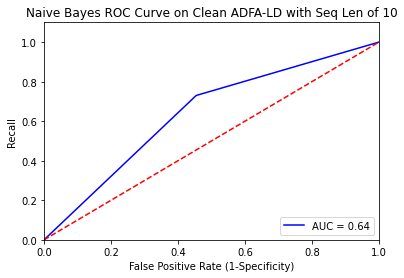

Train AUC: 0.643 vs Test AUC: 0.638


In [ ]:
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes classifier and train with training set
NaiveBayes = GaussianNB()
NaiveBayes.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = NaiveBayes.predict(x_train)
NB_train = {}
NB_train['fpr'], NB_train['tpr'], thresh = roc_curve(y_train, y_pred)
NB_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict testing data
y_predicted = NaiveBayes.predict(x_test)

# Print performance measures
print_performance('Naive Bayes',y_test, y_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
NB_test = {}
NB_test['fpr'], NB_test['tpr'], thresh = roc_curve(y_test, y_predicted)
NB_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(NB_train['auc'], NB_test['auc']))

# **Graphing multi-ROC Curves**

In [ ]:
# Ploting the overlaid ROC curves on testing results:
#graph_multi_ROC()

In [ ]:
print('KM_test =', KM_test)
print('LR_test =', LR_test)
print('SVM_test =', SVM_test)
print('NN_test =', NN_test)
print('DT_test =', DT_test)
print('RF_test =', RF_test)
print('KNN_test =', KNN_test)
print('NB_test =', NB_test)

KM_test = {'fpr': array([0.        , 0.35013832, 1.        ]), 'tpr': array([0.        , 0.62587413, 1.        ]), 'auc': 0.6378679010168027}
LR_test = {'fpr': array([0.        , 0.65637103, 1.        ]), 'tpr': array([0.        , 0.88499962, 1.        ]), 'auc': 0.6143142912041955}
SVM_test = {'fpr': array([0.        , 0.47462978, 1.        ]), 'tpr': array([0.        , 0.74281488, 1.        ]), 'auc': 0.6340925485605338}
NN_test = {'fpr': array([0.        , 0.63648495, 1.        ]), 'tpr': array([0.        , 0.89239607, 1.        ]), 'auc': 0.627955559180758}
DT_test = {'fpr': array([0.        , 0.19218877, 1.        ]), 'tpr': array([0.        , 0.87937063, 1.        ]), 'auc': 0.8435909290059005}
RF_test = {'fpr': array([0.        , 0.12218063, 1.        ]), 'tpr': array([0.        , 0.92180896, 1.        ]), 'auc': 0.8998141628040858}
KNN_test = {'fpr': array([0.        , 0.26317331, 1.        ]), 'tpr': array([0.        , 0.80235149, 1.        ]), 'auc': 0.7695890915118555}
NB_te

# **Note**

**Cleaned Data**
After changing the sequence length to 15 and only removing duplicate data in intrusion has significantly increased all model performances. BERT and GPT outperform the rest with over 0.97 AUC scores.

# **Write performance measures to file**

In [ ]:
# Save performance measure dict of each model to a file
def write_to_file (varname, model_name):
  clean_status = 'clean' if CLEAN else 'unclean'
  filename = DATA +'-'+ str(SEQ_WINDOW) +'-'+ clean_status + ".txt"
  file = open(filename, "a")
  str_dictionary = repr(varname)
  file.write("{}_test = ".format(model_name) + str_dictionary + "\n")
  file.close()


In [ ]:
write_to_file(KM_test, 'KM')
write_to_file(LR_test, 'LR')
write_to_file(SVM_test, 'SVM')
write_to_file(NN_test, 'NN')
write_to_file(DT_test, 'DT')
write_to_file(RF_test, 'RF')
write_to_file(KNN_test, 'KNN')
write_to_file(NB_test, 'NB')


print('KM_test =', KM_test)
print('LR_test =', LR_test)
print('SVM_test =', SVM_test)
print('NN_test =', NN_test)
print('DT_test =', DT_test)
print('RF_test =', RF_test)
print('KNN_test =', KNN_test)
print('NB_test =', NB_test)
print('BERT_test =', BERT_test)
print('GPT_test =', GPT_test)
